In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

2023-04-15 21:13:05.064342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_hourly = pd.read_csv(os.getcwd() + '/Datasets/Ontario/Hourly_Electricity_Ontario.csv')

### Rule for merging hour -> daily
- max temp
- max snow depth (not reasonable)
- max snowfall
- max precip
- max irradiance
- max cloud coverage 
- max air density 
- sum all energy

In [3]:
df_daily = pd.read_csv(os.getcwd() + '/Datasets/Ontario/Daily_Electricity_Ontario.csv')

In [4]:
def season(date):
    month = date.month
    season = None
    if month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    elif month in [9, 10, 11]:
        season = 'fall'
    elif month in [12, 1, 2]:
        season = 'winter'
    return season

# Separate the time column into dates and hour column 
df_hourly['dates'] = pd.to_datetime(df_hourly['time']).dt.date
df_hourly['hour'] = pd.to_datetime(df_hourly['time']).dt.hour

# Create the season column
df_hourly['season'] = df_hourly.apply(lambda x: season(x['dates']), axis=1)

In [5]:
def bar_plot(df, column_type='hour'):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=column_type, y='Total Energy Use from Electricity (MW)', data=df, ci=None, estimator=sum)
    plt.title(f'{column_type}ly energy consumption')
    plt.xlabel(f'{column_type} of the day')
    plt.ylabel('Total Energy Consumption')
    plt.show()

In [6]:
def box_plot(df, by_type='hour'):
    fig = plt.figure()
    ax = df.boxplot(by=by_type, column='Total Energy Use from Electricity (MW)', figsize=(10, 6))
    plt.xlabel(f"{by_type} type")
    plt.ylabel("Total Energy Use from Electricity (MW)")
    ax.tick_params(axis='x', rotation=90)
    plt.show()

In [7]:
def get_period(df, start_date, end_date, col_name='dates'):
    df_start = df[df[col_name] >= pd.to_datetime(start_date)]
    return df_start[df_start[col_name] <= pd.to_datetime(end_date)]

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_89080/933044428.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=column_type, y='Total Energy Use from Electricity (MW)', data=df, ci=None, estimator=sum)


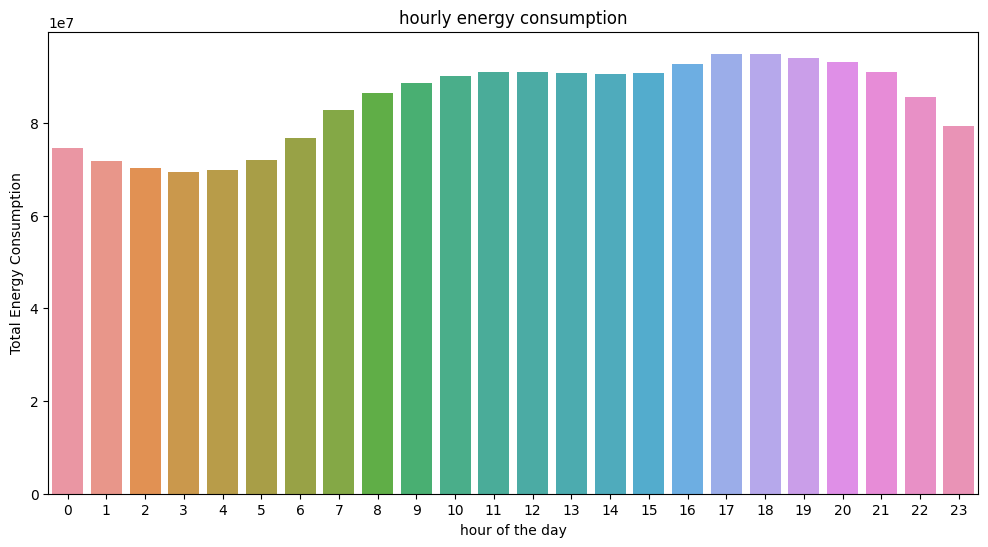

In [8]:
bar_plot(df_hourly)

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_89080/933044428.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=column_type, y='Total Energy Use from Electricity (MW)', data=df, ci=None, estimator=sum)


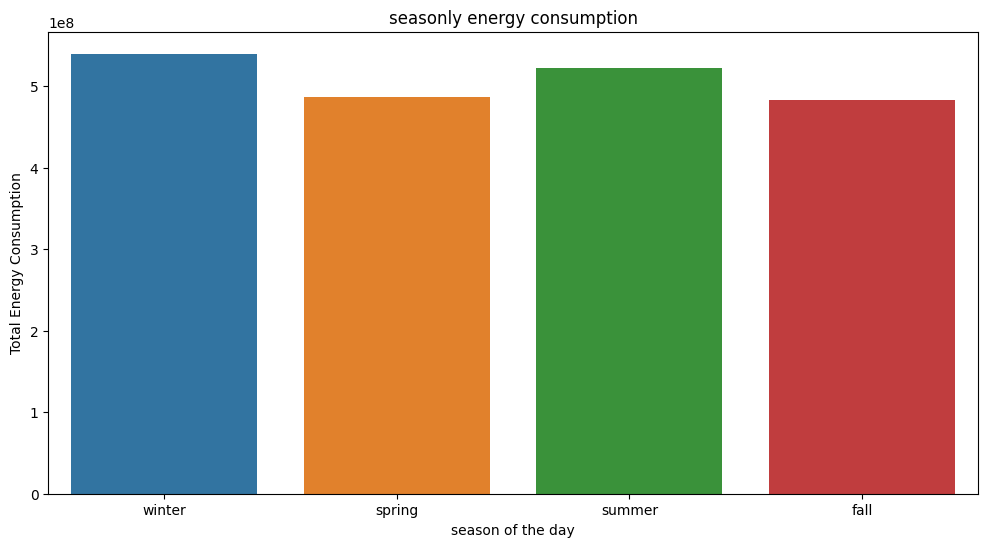

In [9]:
bar_plot(df_hourly, column_type='season')

In [10]:
df_hourly_test = df_hourly.copy()
df_hourly_test['month'] = pd.to_datetime(df_hourly['dates']).dt.month

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_89080/933044428.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=column_type, y='Total Energy Use from Electricity (MW)', data=df, ci=None, estimator=sum)


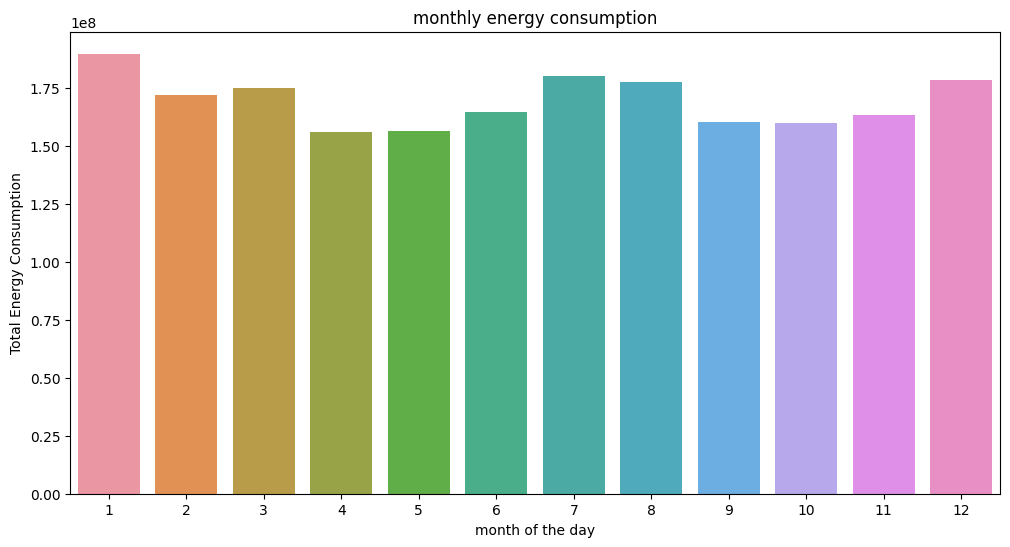

In [11]:
bar_plot(df_hourly_test, column_type='month')

Observation:

- January, December, July, August are the four months with highest energy consumption. 
- It can be explained by (Jan, Dec) - coldest months, (July, Aug) - hottest months

In [12]:
start_date = '2016-01-01'
end_date = '2016-12-31'
df_2016 = get_period(df_hourly, start_date, end_date)

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_89080/3640062300.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_start = df[df[col_name] >= pd.to_datetime(start_date)]
/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_89080/3640062300.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df_start[df_start[col_name] <= pd.to_datetime(end_date)]


In [13]:
start_date = '2015-01-01'
end_date = '2015-12-31'
df_2015 = get_period(df_hourly, start_date, end_date)

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_89080/3640062300.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_start = df[df[col_name] >= pd.to_datetime(start_date)]
/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_89080/3640062300.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df_start[df_start[col_name] <= pd.to_datetime(end_date)]


<Figure size 640x480 with 0 Axes>

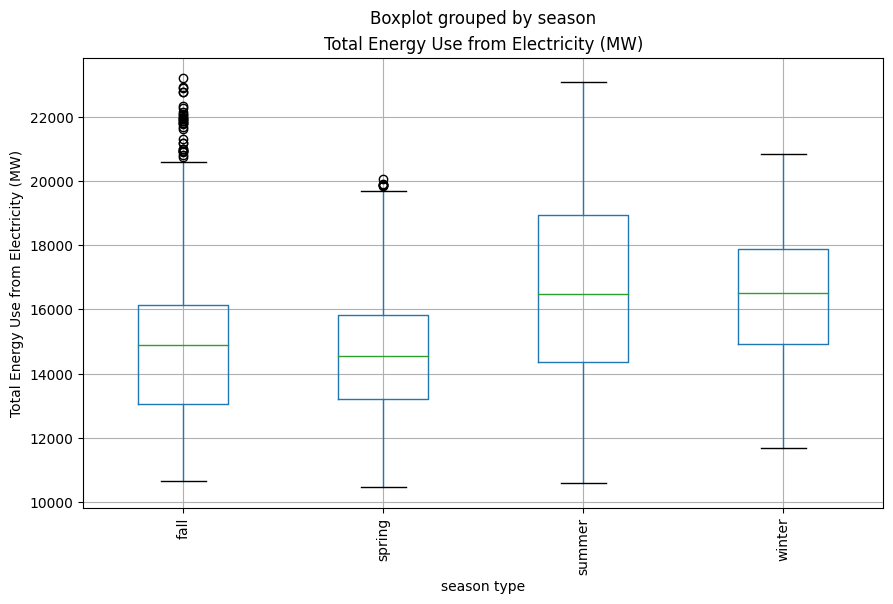

In [14]:
box_plot(df_2016, by_type='season')

<Figure size 640x480 with 0 Axes>

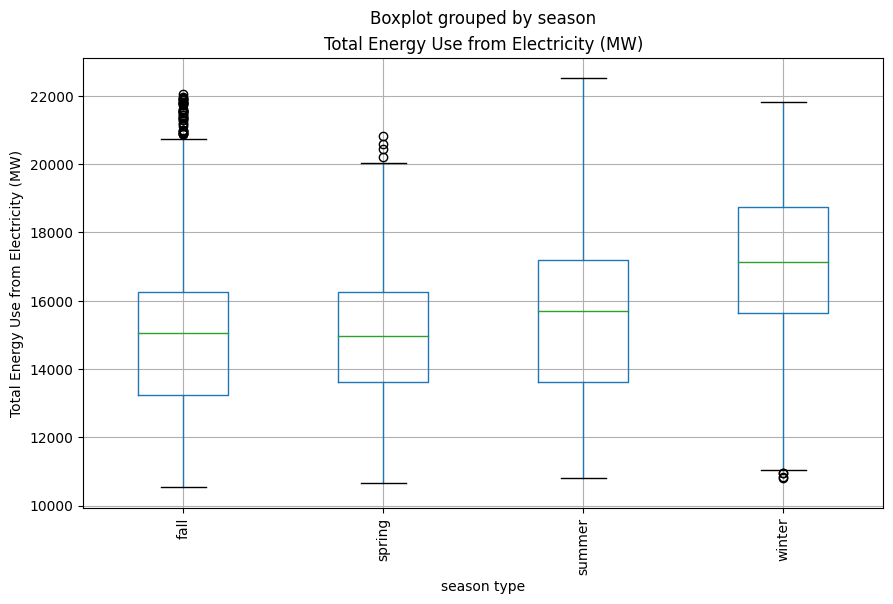

In [15]:
box_plot(df_2015, by_type='season')

## Exploratory Analysis

### From 2003

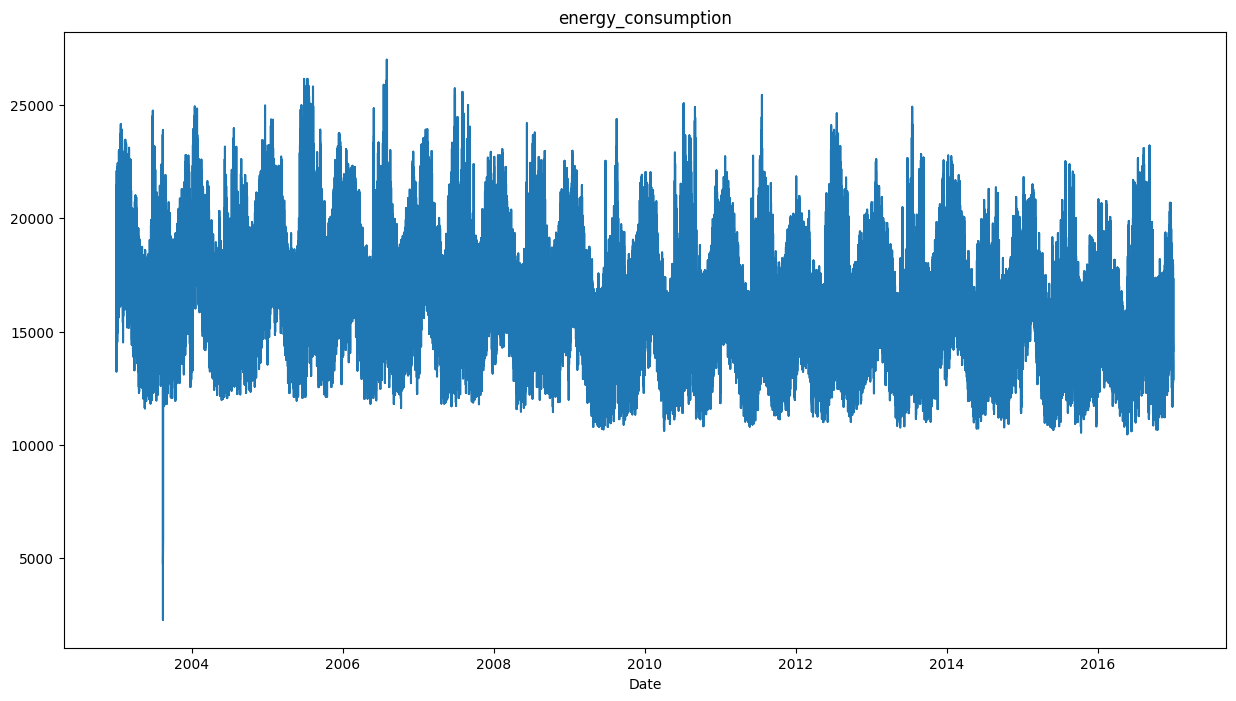

In [16]:
plt.figure(figsize=(15,8))
plt.title('energy_consumption')
plt.plot(df_hourly['dates'], df_hourly['Total Energy Use from Electricity (MW)'])
plt.xlabel('Date')
plt.show()

### From 2004

In [17]:
df_hourly['time'] = pd.to_datetime(df_hourly['time'])
df_hourly_2004 = df_hourly[df_hourly['time'].dt.year != 2003]

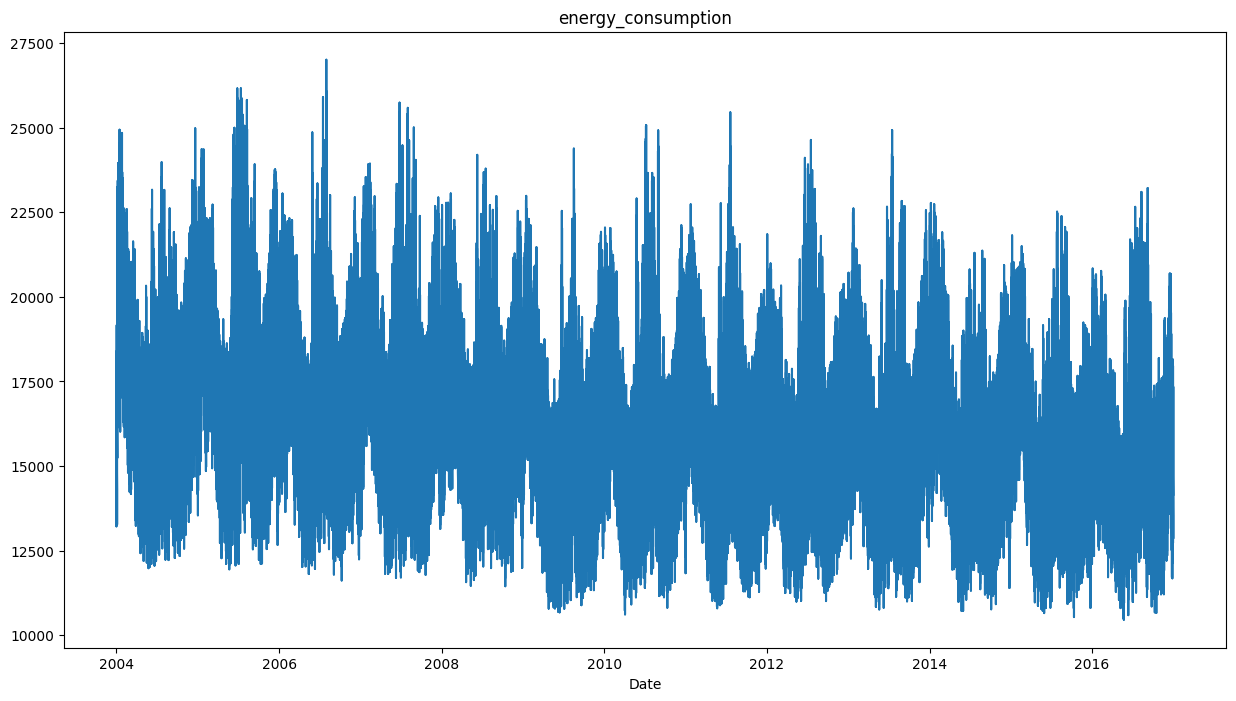

In [18]:
plt.figure(figsize=(15,8))
plt.title('energy_consumption')
plt.plot(df_hourly_2004['dates'], df_hourly_2004['Total Energy Use from Electricity (MW)'])
plt.xlabel('Date')
plt.show()